In August 2015, the NYC Taxi and Limosine Commission released taxi data up through June 2015. 
This project analyzes some of that data, which is available at: 
    http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

In [34]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams  

## Getting and Checking the Data

In [3]:
# Read in the data. We'll just start with the data for June, 2015, for  yellow cabs.
yellowDF = pd.read_csv('Data/yellow_tripdata_2015-06.csv')

In [165]:
print yellowDF.shape

(12039302, 18)


Just the data in June gives us over 12 million records. We don't need all 18 columns, but we'll leave them for now. However, it might be nice to clean up the labels a bit. Then we'll need to clean the data to remove anything that won't help us, like NaNs, trips that take zero time, or those that clearly have incorrect entries.

In [10]:
labels = ['VendorID', 'pickup_time', 'dropoff_time', 'passenger_count', 'distance', 'pickup_long', 'pickup_lat', 
         'RateCodeID', 'flag', 'dropoff_long', 'dropoff_lat', 'payment_type', 'fare', 'extra', 'mta_tax',
         'tip', 'tolls', 'total']
yellowDF.columns = labels

In [33]:
# Let's get the summary of this dataframe to get an idea of what we have. 
# Then we'll just print out some of the values of interest.
summary = yellowDF.describe()

print 'Min distance:', summary.loc['min','distance'], '\t\t', 'Max distance:', summary.loc['max','distance']
print 'Min passenger count:', summary.loc['min', 'passenger_count'], '\t', \
        'Max passenger count:', summary.loc['max', 'passenger_count']
print 'Min longitude:', min(summary.loc['min', 'pickup_long'], summary.loc['min', 'dropoff_long']), '\t', \
        'Max longitude:', max(summary.loc['max', 'pickup_long'], summary.loc['max', 'dropoff_long'])
print 'Min latitude:', min(summary.loc['min', 'pickup_lat'], summary.loc['min', 'dropoff_lat']), '\t', \
        'Max latitude:', max(summary.loc['max', 'pickup_lat'], summary.loc['max', 'dropoff_lat'])
print 'Min total fare:', summary.loc['min', 'total'], '\t\t', 'Max total fare:', summary.loc['max', 'total']

Min distance: 0.0 		Max distance: 10083318.0
Min passenger count: 0.0 	Max passenger count: 9.0
Min longitude: -759.233337402 	Max longitude: 149.028533936
Min latitude: -67.1369628906 	Max latitude: 483.450012207
Min total fare: -300.0 		Max total fare: 335414.49


Uh oh. Looks like there are some wacky values here. A longitude of -759.23 goes around the Earth twice, then ends up somewhere in the Atlantic Ocean. In the next section, we'll clean up the data so we remove the entries that don't make sense. 

## Cleaning the Data

Here's what we'd like to get rid of:
* Trips that take zero time or have zero distance
* Trips that take many hours or have distances more than 100 miles
* Trips that start or end far outside of New York City
* Fares that are below zero, or far above anything reasonable

In [35]:
# Remove any rows that include NaNs.
yellowDF = yellowDF.dropna()

# Remove distances less than zero or over 100 miles
yellowDF = yellowDF[(yellowDF.distance > 0) & (yellowDF.distance < 100)]

# Only get trips in NYC
yellowDF = yellowDF[(yellowDF.pickup_long >= -74.1) & (yellowDF.pickup_long <= -73.7) & \
                   (yellowDF.dropoff_long >= -74.1) & (yellowDF.dropoff_long <= -73.7) & \
                   (yellowDF.pickup_lat >= 40.6) & (yellowDF.pickup_lat <= 41.0) & \
                   (yellowDF.dropoff_lat >= 40.6) & (yellowDF.dropoff_lat <= 41.0)]

# Remove trips with total fares less than zero or more than $200. (Yes, it's possible to spend more on a 
# cab rise in NYC, but some of those were for short trips, so they seem like bad data.)
yellowDF = yellowDF[(yellowDF.total > 0) & (yellowDF.total < 200)]

At this point, we've removed 293,078 records, which is only about 2.4%.

## Visualizing the Pickup and Dropoff Locations



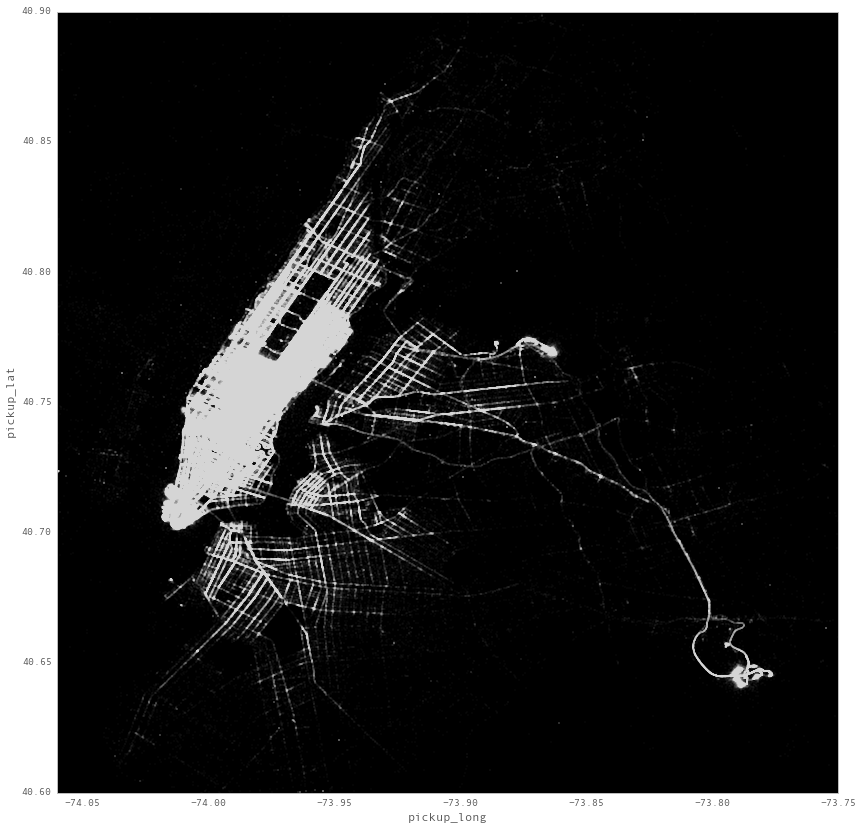

In [164]:
# Some of this code was borrowed from Daniel Forsyth's code at http://www.danielforsyth.me/mapping-nyc-taxi-data/ 
# and modified.
# Here's the comment from Hacker News user 'eck' on how he did it:
# "The process of making it was quite simple. I zeroed a 2d array of integers, then took all the pickup/dropoff 
# points and incremented the nearest cell. The pixel values are based on the logarithm of the counts, 
# since otherwise everything outside midtown would be pretty much black."
%matplotlib inline

pd.options.display.mpl_style = 'default'

rcParams['figure.figsize'] = (14, 14) # Figure size in inches
rcParams['figure.dpi'] = 250

# Just get the pickup locations, then plot those as a scatter plot.
pickup = yellowDF.loc[:, ['pickup_long', 'pickup_lat']]
P = pickup.plot(kind='scatter', x='pickup_long', y='pickup_lat', color='white',
              xlim=(-74.06,-73.75), ylim=(40.6, 40.9), s=.01, alpha=.5)

# Close up of downtown
# P = pickup.plot(kind='scatter', x='pickup_long', y='pickup_lat', color='white',
#               xlim=(-74.01,-73.95), ylim=(40.7, 40.8), s=.01, alpha=.5)

P.set_axis_bgcolor('black') # Make the background black

This is a good start. Unfortunately, there's a lot more activity downtown, so that area is saturated with points. We need to refine the image. 

Rather than make a scatter plot from the dataframe, we can create an array where each cell represents a latitude and longitude value. We increment each cell based on the number of taxi trips that began or ended there. To even out the values, we can take the logarithm, so that the outlying areas show up nearly as well as the downtown area. We then we create an image from that revised array.

In [162]:
# Create a dataframe of just the pickup and dropoff data
trip = yellowDF.loc[:, ['pickup_long', 'pickup_lat', 'dropoff_long', 'dropoff_lat']]

In [147]:
# Normalize the values so they fall between 0 and 3999, which are the limits of the indices of 
# the 4000 x 4000 image we'll create.
trip.pickup_long = trip.pickup_long - min(trip.pickup_long)
trip.pickup_lat = trip.pickup_lat - min(trip.pickup_lat)
trip.dropoff_long = trip.dropoff_long - min(trip.dropoff_long)
trip.dropoff_lat = trip.dropoff_lat - min(trip.dropoff_lat)

trip = np.round(trip*9997, 0)

trip.describe()

,pickup_long,pickup_lat,dropoff_long,dropoff_lat
count,12039302.000000,12039302.000000,12039302.000000,12039302.000000
mean,1262.846478,1507.497242,1266.738474,1516.884946
std,379.551182,277.579511,339.673697,312.749140
min,0.000000,0.000000,0.000000,0.000000
25%,1079.000000,1373.000000,1086.000000,1362.000000
50%,1181.000000,1539.000000,1200.000000,1544.000000
75%,1324.000000,1682.000000,1363.000000,1691.000000
max,3998.000000,3990.000000,3999.000000,3995.000000


In [149]:
# Initialize a 2-D arrays of ones. We use ones here instead of zeros because we'll be taking the 
# log of the final values later, and we can't take the log of zero.
log_vals = np.ones((4000,4000))

# For every pickup or dropoff location that matches an array location, increment the value
# of that element. Each element represents a pixel of the final image.
# Note that the y-values, i.e., the latitudes, need to be reversed.
def incr_ar(row):
    log_vals[3999-row['pickup_lat'], row['pickup_long']] += 1
    log_vals[3999-row['dropoff_lat'], row['dropoff_long']] += 1
    
t = trip.apply(incr_ar, axis=1)


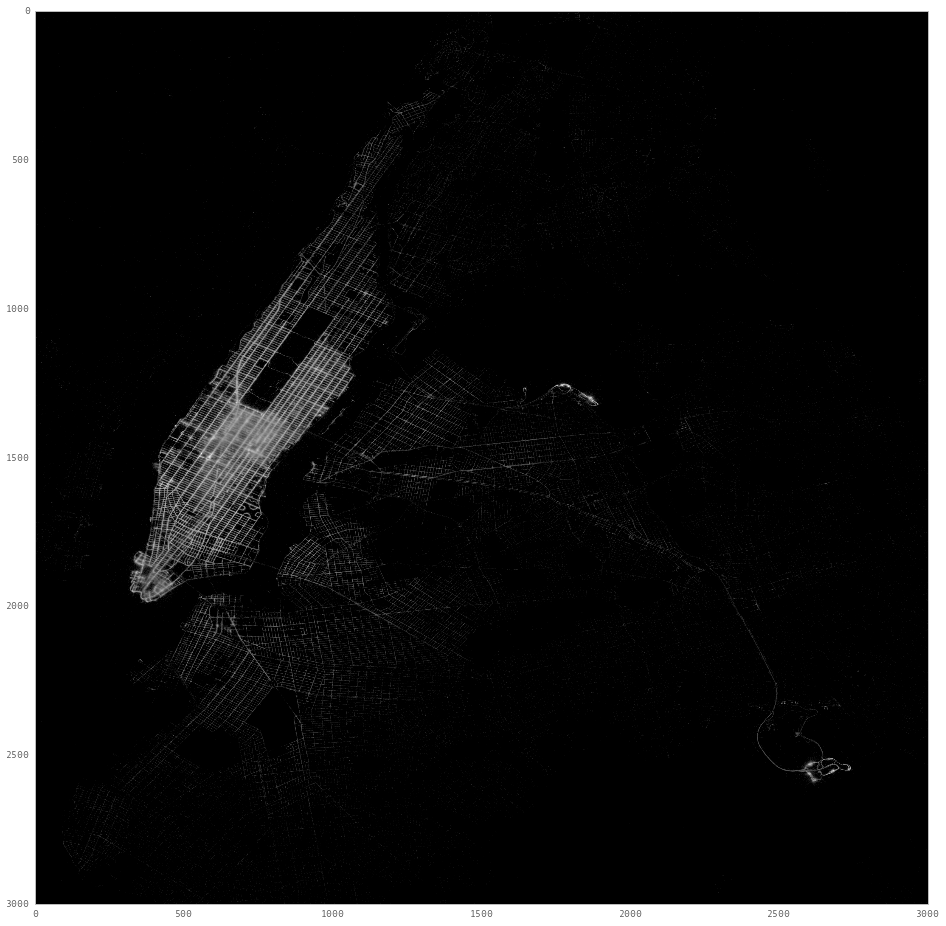

In [161]:
%matplotlib inline

pd.options.display.mpl_style = 'default'

# # This creates a figure that is 4000 x 4000 pixels
rcParams['figure.figsize'] = (16, 16) # Figure size in inches
rcParams['figure.dpi'] = 250

# Take the log of the values.
log_vals10 = np.log(log_vals)

plt.imshow(log_vals10[1000:4000, 500:3500])
plt.show()


This is looking much cleaner! Since we only have one month of data, I included both the pickup and dropoff locations. Otherwise, the image would have been too light. Still, the city and the airport show up quite well, but for a more complete picture we'd use data from several months, or an entire year.